In [1]:
import sys
sys.path.append('../')
import torch
import dill
import os.path as op
import numpy as np
import hnn_core
from hnn_core import simulate_dipole, Network, read_params, JoblibBackend
import matplotlib as mpl
import matplotlib.pyplot as plt
import sbi.utils as utils
from sbi.inference.base import infer
import multiprocessing
import datetime
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from scipy import interpolate
import glob
import pandas as pd
import spike_train_functions
import hnn_simnets_functions
import numba
import sbi_functions
from sbi_functions import run_simulator
from joblib import Parallel, delayed
import umap
import umap.plot


/home/ntolley/anaconda3/lib/python3.7/site-packages/elephant/pandas_bridge.py:22: DeprecationWarning: pandas_bridge module will be removed in Elephant v0.8.x
  DeprecationWarning)
/home/ntolley/anaconda3/lib/python3.7/site-packages/holoviews/operation/datashader.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Callable


In [2]:
data_path = '/home/ntolley/Jones_Lab/sbi_hnn/data/ERP/prerun_simulations/ERP_No_t10000_01162021_121408/'

prior_dict_file = open(data_path + 'prior_dict_ERP_No_t10000_01162021_121408.pkl', 'rb')
prior_dict = dill.load(prior_dict_file)
prior_dict_file.close()

prior_file = open(data_path + 'prior_ERP_No_t10000_01162021_121408.pkl', 'rb')
prior = dill.load(prior_file)
prior_file.close()

# params_fname_file = open(data_path + 'params_fname_ERP_No_t10000_01162021_121408.pkl', 'rb')
# params_fname = dill.load(params_fname_file)
# params_fname_file.close()
params_fname = '../../data/ERP/ERPNo.param'

dpl_files = sorted(glob.glob(data_path + 'data/dpl*'))
theta_files = sorted(glob.glob(data_path + 'data/theta*'))
spike_gids_files = sorted(glob.glob(data_path + 'data/spike_gids*'))
spike_times_files = sorted(glob.glob(data_path + 'data/spike_times*'))
spike_types_files = sorted(glob.glob(data_path + 'data/spike_types*'))

In [3]:
file_idx = 0
dpl = np.loadtxt(dpl_files[file_idx],delimiter=',')
theta = np.loadtxt(theta_files[file_idx],delimiter=',')

# dpl = np.vstack([np.loadtxt(dpl_files[file_idx],delimiter=',') for file_idx in range(len(dpl_files))])
# theta = np.vstack([np.loadtxt(theta_files[file_idx],delimiter=',') for file_idx in range(len(theta_files))])

ERPYes_dpl = np.loadtxt('../../data/ERP/ERPYes_dpl.txt', delimiter=',')
ERPNo_dpl = np.loadtxt('../../data/ERP/ERPNo_dpl.txt', delimiter=',')

# with open(spike_gids_files[file_idx], 'rb') as f:
#     spike_gids = dill.load(f)
# unique_gids = np.unique([gid for l in spike_gids for gid in l[0]])
# num_sims = len(spike_gids)

# with open(spike_times_files[file_idx], 'rb') as f:
#     spike_times = dill.load(f)

# spike_times_list = []
# for gid in unique_gids:
#     unit_trains = []
#     for sim_idx in range(num_sims):
#         gid_mask = np.in1d(spike_gids[sim_idx][0], gid)
#         unit_trains.append(np.array(spike_times[sim_idx][0])[gid_mask])
#     spike_times_list.append(unit_trains)



In [4]:
inference = SNPE(prior=prior)
inference = inference.append_simulations(torch.as_tensor(theta).float(), torch.as_tensor(dpl).float())
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

/home/ntolley/anaconda3/lib/python3.7/site-packages/nflows/transforms/standard.py:76: DeprecationWarning: Use PointwiseAffineTransform
  warnings.warn("Use PointwiseAffineTransform", DeprecationWarning)
/home/ntolley/anaconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag
Neural network successfully converged after 48 epochs.


In [5]:
num_samples = 10
theta_samples_No = posterior.sample((num_samples,), x=ERPNo_dpl)
theta_samples_Yes = posterior.sample((num_samples,), x=ERPYes_dpl)

In [6]:
res_No = Parallel(n_jobs=8)(delayed(run_simulator)(theta_samples_No[sim_idx,:], params_fname, prior_dict, sim_idx) for sim_idx in range(num_samples))
res_Yes = Parallel(n_jobs=8)(delayed(run_simulator)(theta_samples_Yes[sim_idx,:], params_fname, prior_dict, sim_idx) for sim_idx in range(num_samples))
res = res_No + res_Yes

In [20]:
spike_times = [res[sim_idx][1][0] for sim_idx in range(len(res))]
spike_gids = [res[sim_idx][2][0] for sim_idx in range(len(res))]
spike_types = [res[sim_idx][3][0] for sim_idx in range(len(res))]
spikes = hnn_simnets_functions.tmpSpikes(spike_times, spike_gids, spike_types)
spikes_df_all = hnn_simnets_functions.make_spikes_df(spikes, num_trials=len(res))
spikes_df_all['detected'] = np.repeat(['No', 'Yes'], num_samples)
spikes_df_all[spikes_df_all['detected'] == 'No']['gid'] = spikes_df_all[spikes_df_all['detected'] == 'No']['gid'] + np.max(spikes_df_all['gid'].values)

In [30]:
spikes_df = spikes_df_all.groupby('gid').agg(lambda x: tuple(x)).applymap(list).reset_index()
spikes_df['type'] = spikes_df['type'].map(lambda x: x[0])

#Format timestamps columns into list of size num_trials, empty lists inserted on trials where no spikes fired
grouped_ts = []
trial_sim = []
for gid in np.unique(spikes_df['gid'].values):
    gid_ts = []
    gid_trial_idx = 0 
    for trial_idx in range(num_samples):
        if trial_idx in spikes_df['trial'][spikes_df['gid'] == gid].values[0]:
            gid_ts.append(np.array(spikes_df['timestamps'][spikes_df['gid'] == gid].values[0][gid_trial_idx]))
            gid_trial_idx = gid_trial_idx + 1
        else:
            gid_ts.append(np.array([]))
    grouped_ts.append(np.array(gid_ts))
    trial_sim.append(spike_train_functions.vpTrialSimilarityMatrix(gid_ts,0.1).reshape((1,-1)).squeeze())
spikes_df['grouped_ts'] = grouped_ts
spikes_df['trial_sim'] = trial_sim

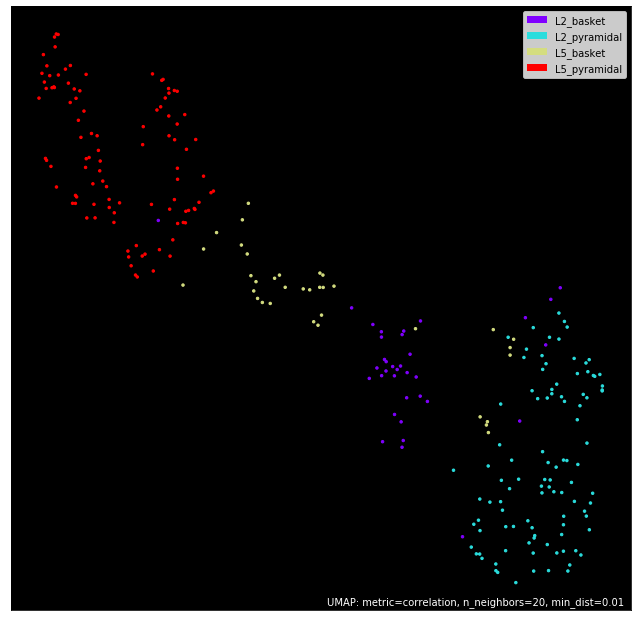

In [31]:
n_neighbors=20
min_dist=0.01
n_components=2
mapper = umap.UMAP(metric='correlation',n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components).fit(np.stack(spikes_df['trial_sim'].values))
umap.plot.points(mapper,labels = spikes_df['type'].values, theme='fire')
# umap.plot.points(mapper,labels = spikes_df_filtered['detected'].values, theme='fire')

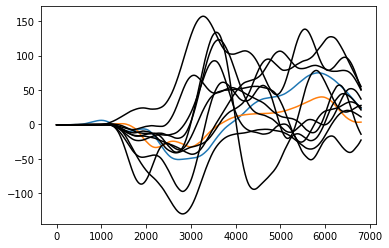

In [18]:
plt.figure()
plt.plot(ERPYes_dpl, 'C0')
plt.plot(ERPNo_dpl, 'C1')
for sim_idx in range(len(res)):
    plt.plot(res[sim_idx][0], 'k')

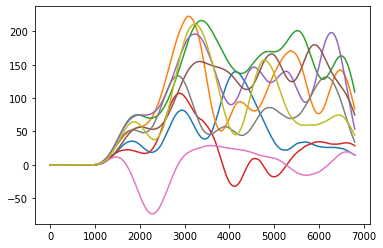

In [17]:
dpl_num = [0,32,63,554,24,6 , 555, 444, 333]
for idx in dpl_num:
    plt.plot(dpl[idx,:])